In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import glob
import time
from helperfunctions import *
from svmclassifier import *

In [2]:
# Read training data 
# Car
cars_files    = glob.glob('C://big/p5/vehicles/**/*.png', recursive=True)
# Not Car
notcars_files = glob.glob('C://big/p5/non-vehicles/**/*.png', recursive=True)

# store filenames in cars,notcars
cars=[]
notcars=[]
# search through readed data 
# read every third image to split time-series of images
for n in range(len(cars_files)):
    if n % 3 == 0:
        cars.append(cars_files[n])
#print(cars)

# Do the same for non-car data
for n in range(len(notcars_files)):
    if n % 3 == 0:
        notcars.append(notcars_files[n])
        
print('Cars size is: ',np.shape(cars))
print('Not-Cars size is: ',np.shape(notcars))

Cars size is:  (0,)
Not-Cars size is:  (0,)


In [3]:
# Testing functions above - pickle_extracted_features()
cspace ='RGB'
orient = 9
pix_per_cell = 4
cell_per_block = 2 
hog_channel = 'ALL'

# Extract the features, then save a pickle file
fname = 'X_scaler_scaled_X_y.p'
if os.path.isfile(fname) == True:
    print('Already Extracted, got my pickle')
    pass
else:
    pickle_extracted_features('X_scaler_scaled_X_y.p',cars,notcars,cspace,orient,
                          pix_per_cell,cell_per_block,hog_channel)

# Test training_with_SVM()
training_with_SVM('X_scaler_scaled_X_y.p')

Already Extracted, got my pickle
5.99 Seconds to train SVC
Test Accuracy of SVC =  0.9775
Model saved as [ svc.pickle ] file
My SVC predictions: 
 [ 1.  0.  1.  1.  0.  1.  0.  1.  0.  0.]
For  10 labels: 
 [ 1.  0.  1.  1.  0.  1.  0.  1.  0.  0.]


find cars cspace is  RGB
(720, 1280, 3)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


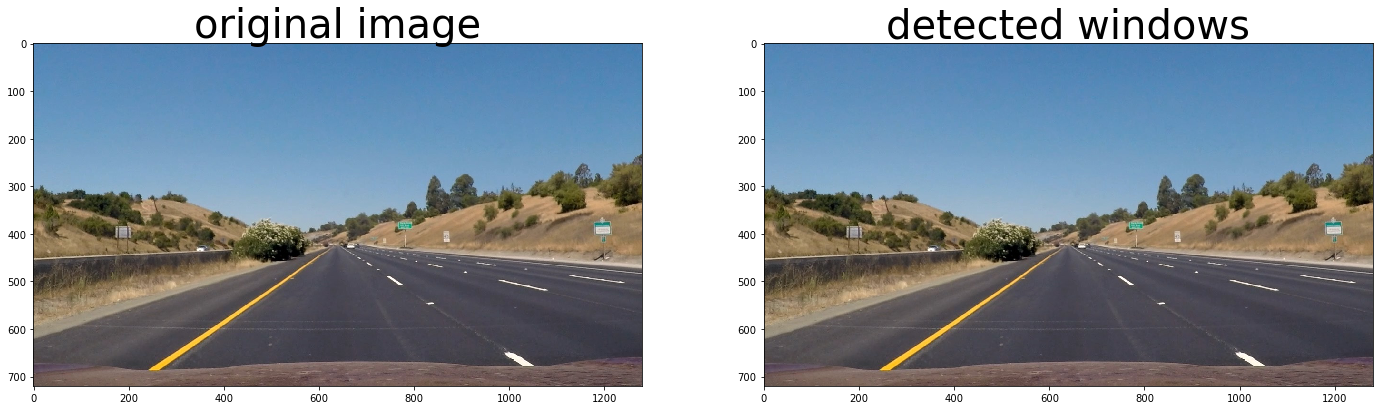

find cars cspace is  RGB
(720, 1280, 3)


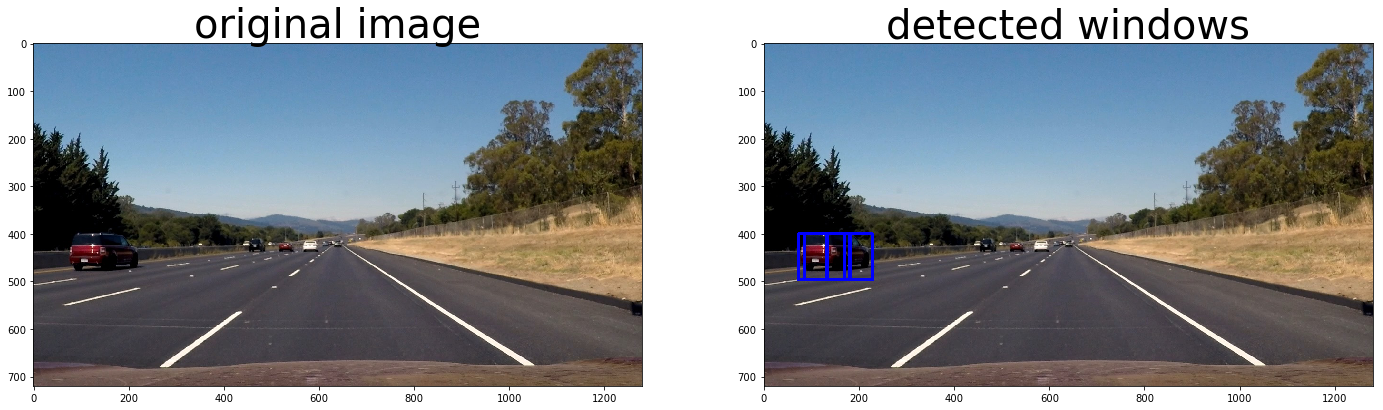

find cars cspace is  RGB
(720, 1280, 3)


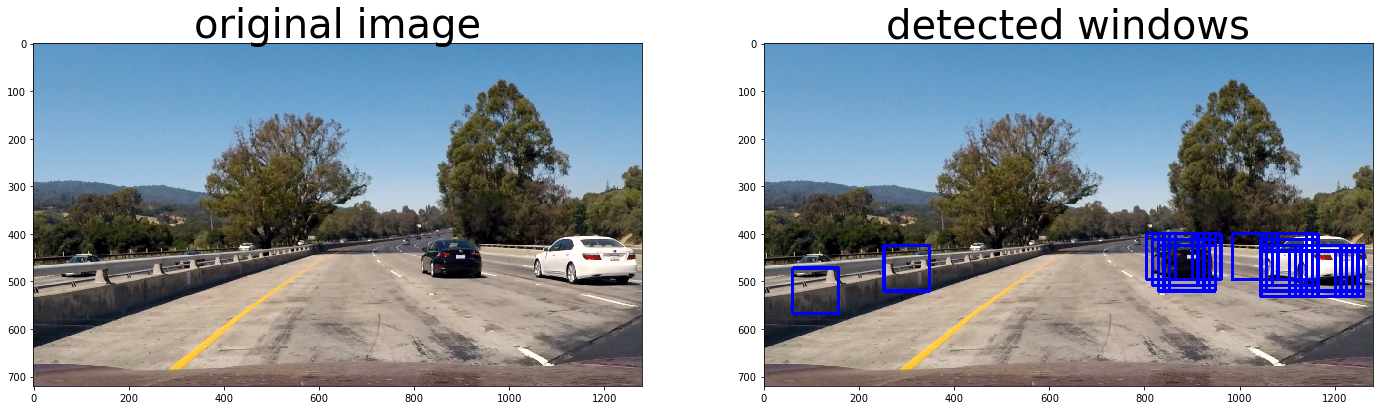

find cars cspace is  RGB
(720, 1280, 3)


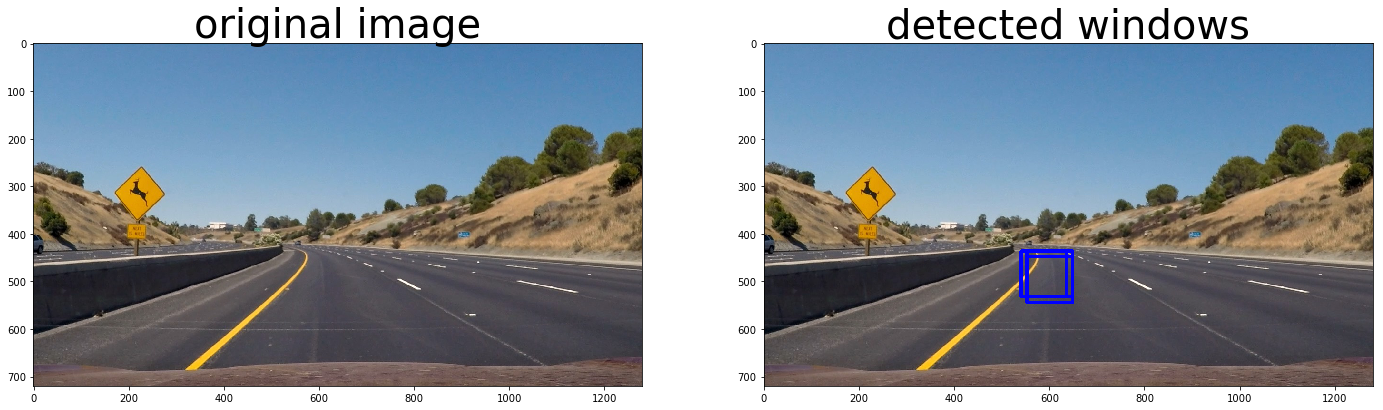

find cars cspace is  RGB
(720, 1280, 3)


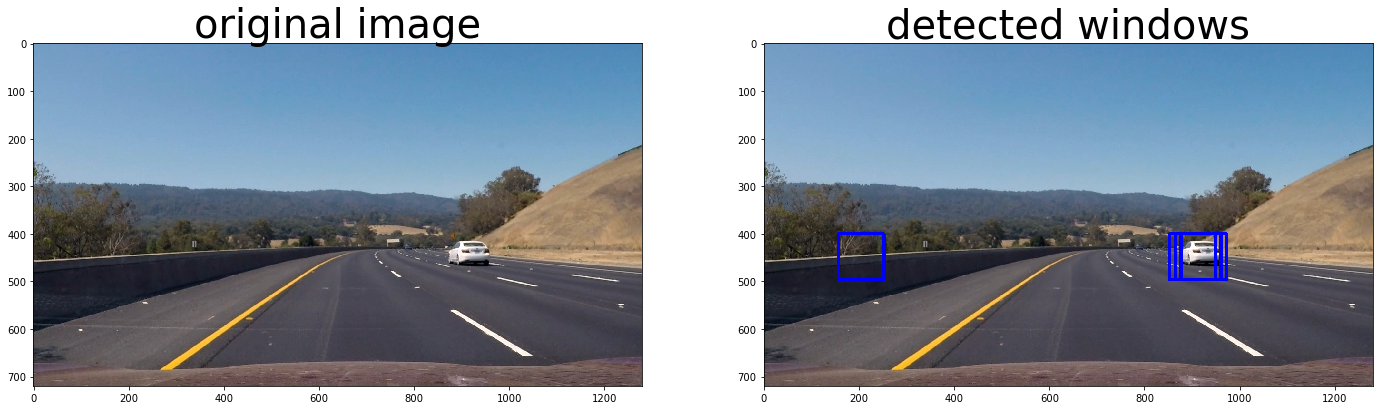

find cars cspace is  RGB
(720, 1280, 3)


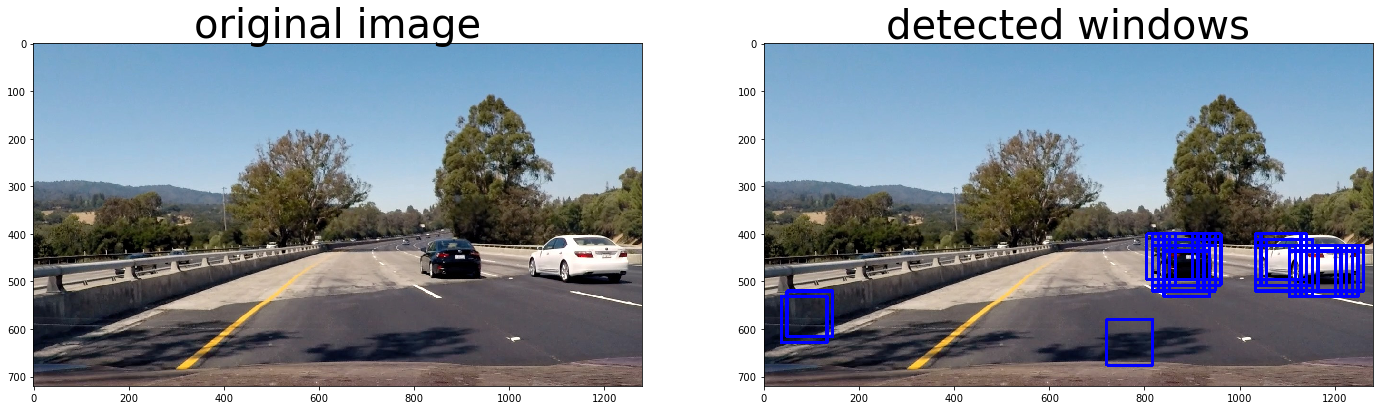

find cars cspace is  RGB
(720, 1280, 3)


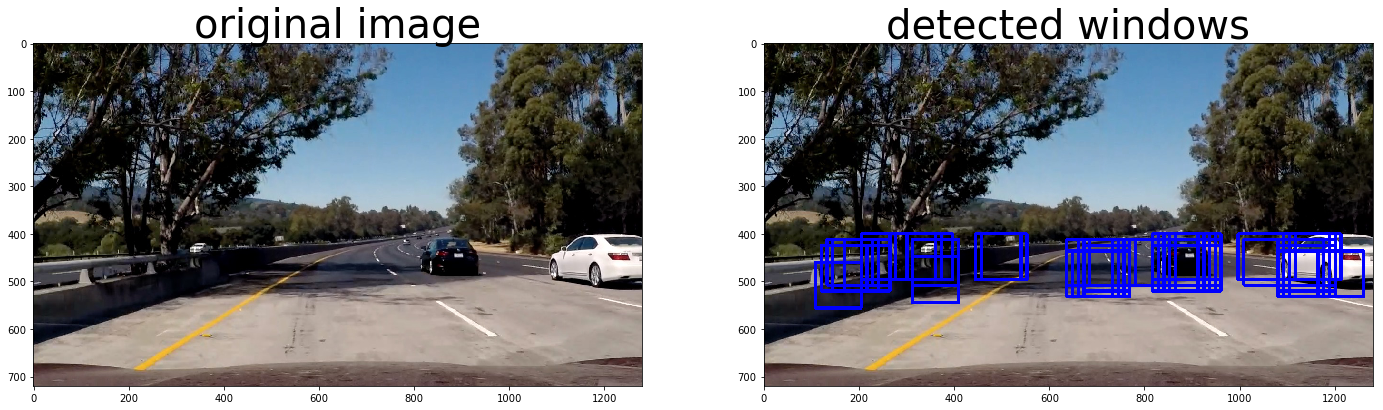

find cars cspace is  RGB
(720, 1280, 3)


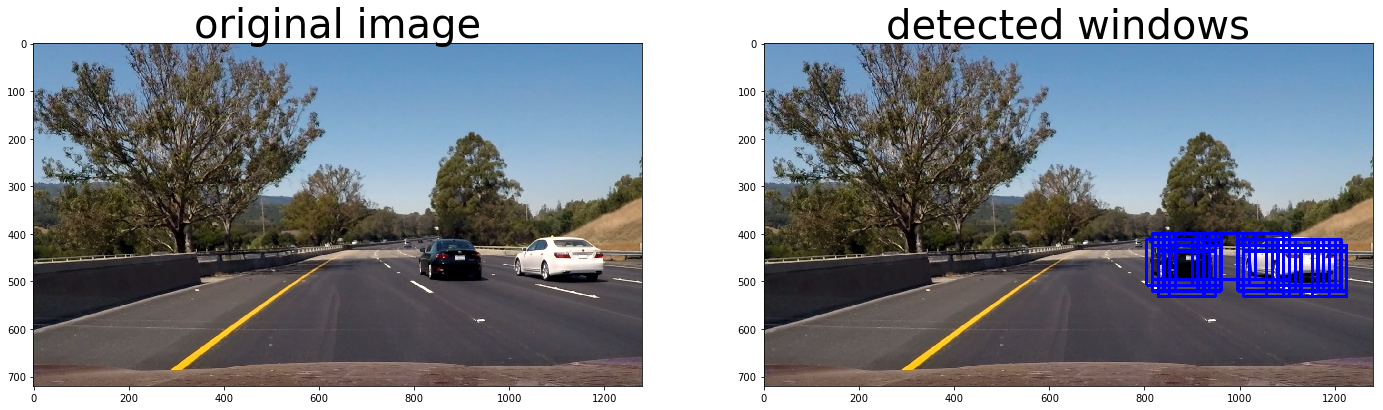

done
[((804, 412), (900, 508)), ((816, 400), (912, 496)), ((816, 412), (912, 508)), ((816, 424), (912, 520)), ((828, 400), (924, 496)), ((828, 412), (924, 508)), ((828, 424), (924, 520)), ((828, 436), (924, 532)), ((840, 400), (936, 496)), ((840, 412), (936, 508)), ((840, 424), (936, 520)), ((852, 400), (948, 496)), ((852, 412), (948, 508)), ((852, 424), (948, 520)), ((852, 436), (948, 532)), ((864, 400), (960, 496)), ((864, 412), (960, 508)), ((864, 424), (960, 520)), ((936, 400), (1032, 496)), ((996, 400), (1092, 496)), ((996, 412), (1092, 508)), ((996, 424), (1092, 520)), ((1008, 400), (1104, 496)), ((1008, 412), (1104, 508)), ((1008, 436), (1104, 532)), ((1020, 412), (1116, 508)), ((1056, 412), (1152, 508)), ((1056, 424), (1152, 520)), ((1056, 436), (1152, 532)), ((1068, 412), (1164, 508)), ((1068, 424), (1164, 520)), ((1080, 412), (1176, 508)), ((1080, 424), (1176, 520)), ((1092, 412), (1188, 508)), ((1092, 424), (1188, 520)), ((1092, 436), (1188, 532)), ((1104, 412), (1200, 508))

In [4]:
# Pull in test Image
image = mpimg.imread('media/test_images/test3.jpg')

# Load the data and trained model weights
scaled_data = pickle.load(open(fname,'rb'))
svc = pickle.load(open('svc.pickle','rb'))    
X_scaler = scaled_data["X_scaler"]

ystart = 400
ystop = 700
scale = 1.5

input_directory = 'media/test_images/'
files = os.listdir(input_directory)
for file in files:
    filename,ext = os.path.splitext(file)
    if ext == '.jpg':
        image = mpimg.imread(input_directory + file)    

        win,img = find_cars(image, ystart, ystop, scale, svc, X_scaler,cspace, orient, 
                            pix_per_cell, cell_per_block)

    f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(image)
    ax1.set_title('original image', fontsize=40)
    ax2.imshow(img)
    ax2.set_title('detected windows', fontsize=40)
    plt.show()
print("done")
print(win)



In [5]:
def search_with_multiscale_windows(img, cspace, orient, pix_per_cell, cell_per_block, 
                                   point_scale_data, spatial_size=(32,32), hist_bins=32):
    
    # Define array to store recent windows
    windows = []
    origin = np.copy(img)
    with open('svc.pickle','rb') as f:
        svc = pickle.load(f)
    
    scal_data = pickle.load(open('X_scaler_scaled_X_y.p','rb'))
    X_scaler = scal_data["X_scaler"]
    
    # input starting y point, stop point, scale with stacked list
    # its used to loop with zip() to maintain combinations
    # ex.
    # point_scale_data = [[a,b,c...]
    #                     [d,e,f...]
    #                     [g,h,i...]]
    #     [ystart=a, ystop=d, scale=g] for 1 Iteration,
    #     [ystart=b, ystop=e, scale=h] for next Iteration .....
    
    ystart=point_scale_data[0]
    ystop=point_scale_data[1]
    scale=point_scale_data[2]
    #print(ystart,ystop,scale)
    
    for y_start,y_end, scales in zip(ystart,ystop,scale):
        win_list, draw_img = find_cars(img, int(y_start), int(y_end), scales, svc, X_scaler, cspace, 
                                       orient,pix_per_cell, cell_per_block)
        
        windows = windows + win_list
    
    return windows

# HOG sub-sampling to search through the image
def find_cars(img, ystart, ystop, scale, svc, X_scaler, cspace, orient, pix_per_cell, 
              cell_per_block, spatial_size=(32,32), hist_bins=32):
    draw_img = np.copy(img)
    # CHECK passed inputs
    #print("for [find_cars] input: ystart/stop:{}/{}, scale={}, cspace={},\
    #      orient={}, pix_per_cell={}, cell_per_block={}".format(ystart,ystop,scale,
    #                                                            cspace,orient,
    #                                                            pix_per_cell,cell_per_block))
    
    # search through image
    img_search = img[ystart:ystop,:,:]
    # 描画するwindow座標データ
    # define window list to draw
    win_list = []
    # 色変換　YCrCb: Y:輝度　Cr:赤系統の色相と彩度　Cb:青系統の色相と彩度
    ctrans_search = convert_color(img_search, conv=cspace)
    # サイズスケール変更時に、サイズ変更
    # change imagesize when scale is not 1.0 
    if scale != 1:
        imshape = ctrans_search.shape
        ctrans_search = cv2.resize(ctrans_search, (np.int(imshape[1]/scale),\
                                                   np.int(imshape[0]/scale)))
    # set channels 
    ch1 = ctrans_search[:,:,0]
    ch2 = ctrans_search[:,:,1]
    ch3 = ctrans_search[:,:,2]
    
    # ブロック、ステップ、featureの設定
    # Define block, steps 
    nx_blocks = (ch1.shape[1] // pix_per_cell) - 1
    ny_blocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    # Define number of blocks per window 
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, define how many cells in each step
    cells_per_step = 2
    nxsteps = (nx_blocks - nblocks_per_window) // cells_per_step
    nysteps = (ny_blocks - nblocks_per_window) // cells_per_step
    
    # HOG特徴量を各チャンネルごとに計算
    # Compute HOG features at each channel 
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xblock in range(nxsteps):
        for yblock in range(nysteps):
            ypos = yblock*cells_per_step
            xpos = xblock*cells_per_step 
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            sub_img = cv2.resize(ctrans_search[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # get color features
            spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins,bins_range=(0,256))
            
            # scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,\
                                                          hog_features)).reshape(1,-1))
            #test_features = np.array(test_features)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                win_list.append(((xbox_left, ytop_draw+ystart),\
                               (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),\
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
    return win_list ,draw_img


In [6]:
# test function above - find_cars
image = mpimg.imread('media/test_images/test3.jpg')

y_half = image.shape[0] // 2
y_end = image.shape[0] #- (y_half % 64)
ystart = [y_half,y_half+100]
ystop = [y_end-100, y_end]
scale = [1.2,2.5]
#ystart = [400]
#ystop = [700]
#scale = [1.5]
point_scale_data = np.vstack((ystart,ystop,scale))
print(point_scale_data)
windows = search_with_multiscale_windows(image, cspace, orient, pix_per_cell, cell_per_block, 
                                         point_scale_data)


print(windows)
print(len(windows))

[[ 360.   460. ]
 [ 620.   720. ]
 [   1.2    2.5]]


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((0, 398), (76, 474)), ((153, 398), (229, 474)), ((163, 388), (239, 464)), ((163, 398), (239, 474)), ((172, 388), (248, 464)), ((432, 369), (508, 445)), ((720, 360), (796, 436)), ((864, 408), (940, 484)), ((873, 398), (949, 474)), ((873, 408), (949, 484)), ((873, 417), (949, 493)), ((883, 398), (959, 474)), ((883, 408), (959, 484)), ((883, 417), (959, 493)), ((892, 408), (968, 484)), ((892, 417), (968, 493)), ((600, 480), (760, 640)), ((600, 520), (760, 680)), ((620, 520), (780, 680))]
19


search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


find cars cspace is  YCrCb
(720, 1280, 3)


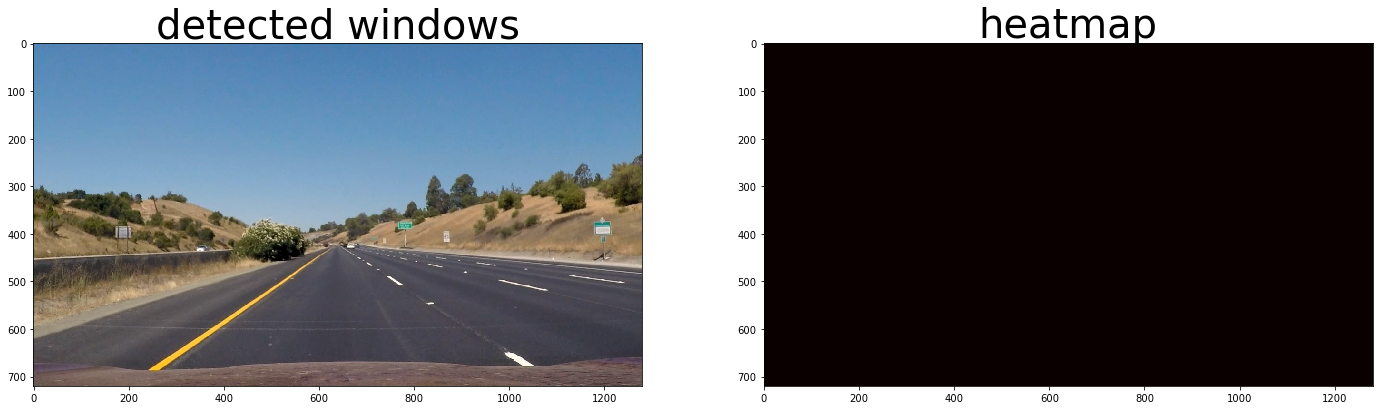

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


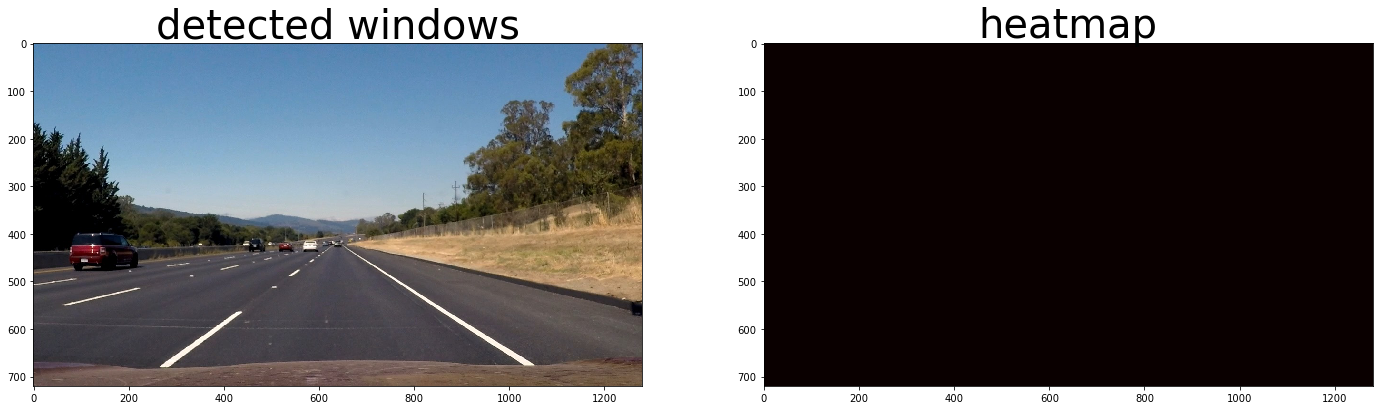

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


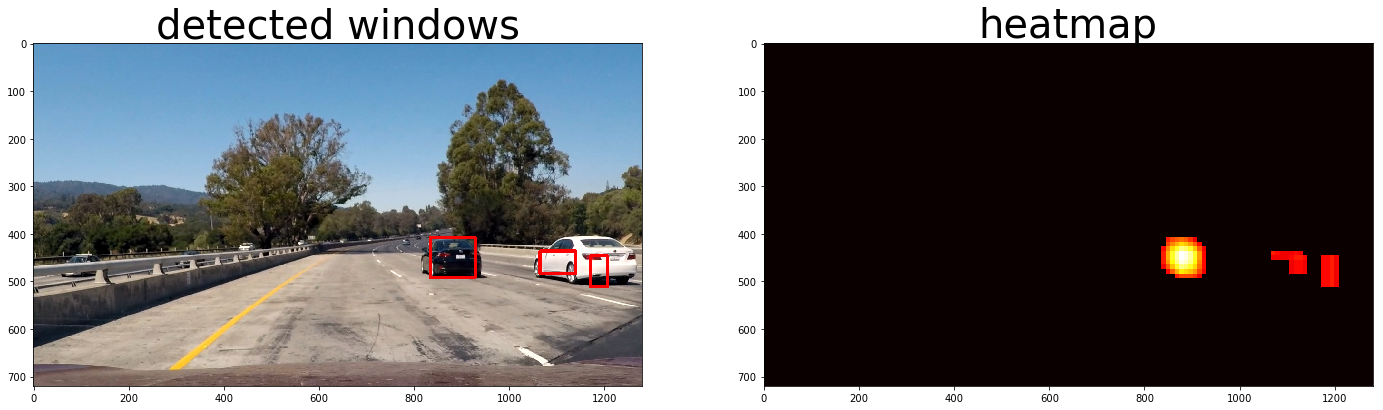

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


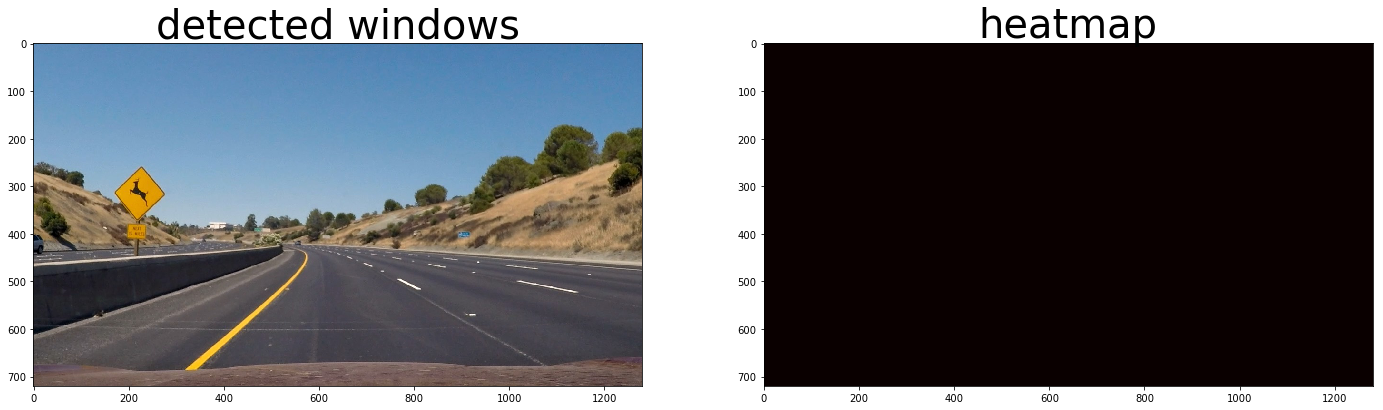

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


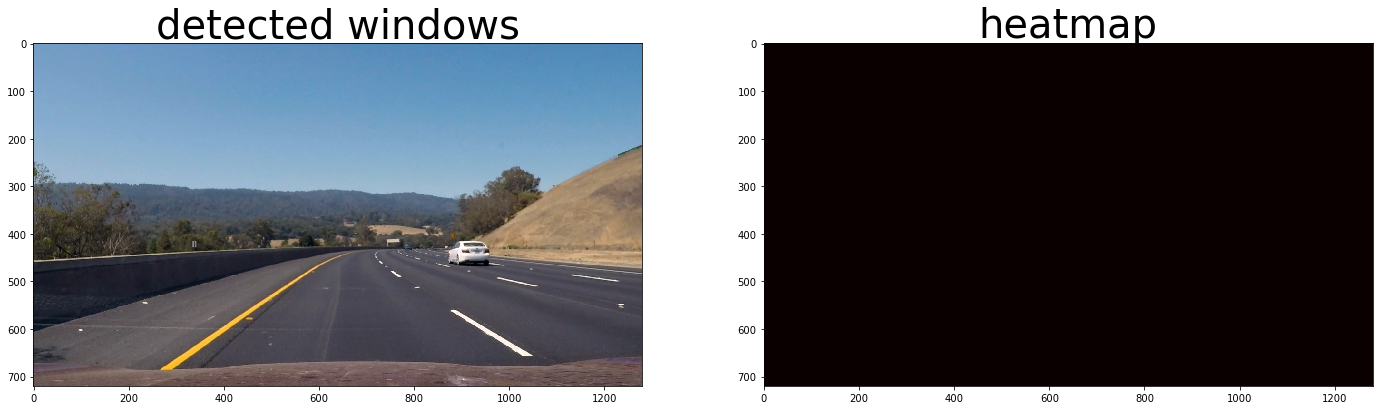

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


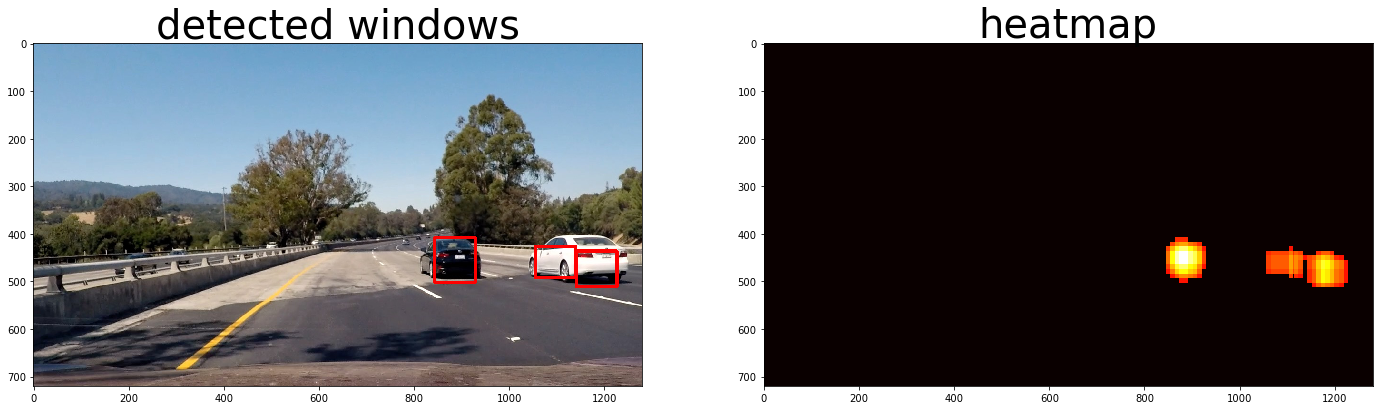

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


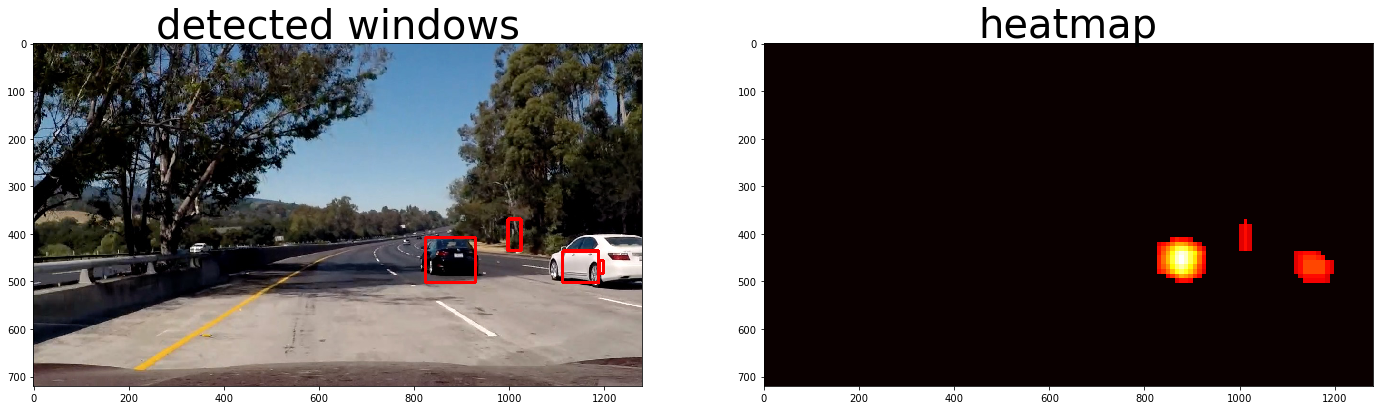

search_with_multiscale cspace is  YCrCb
find cars cspace is  YCrCb
(720, 1280, 3)
find cars cspace is  YCrCb
(720, 1280, 3)


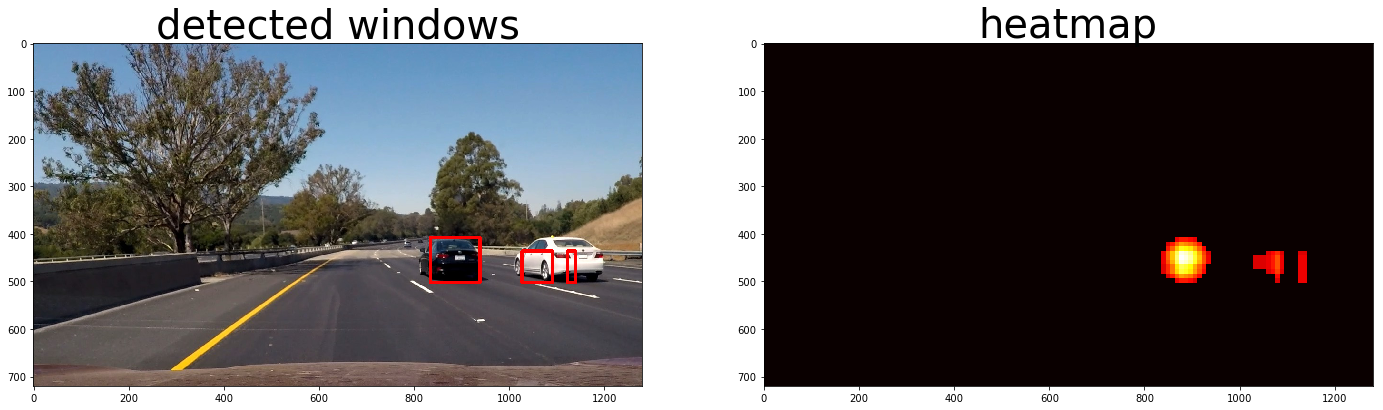

done


In [7]:


# test multiscale window search and heatmap
cspace = "YCrCb"
input_directory = 'media/test_images/'
files = os.listdir(input_directory)
for file in files:
    filename,ext = os.path.splitext(file)
    if ext == '.jpg':
        image = mpimg.imread(input_directory + file)    

        # When moving function to outside script, had to pass all the arguments
        # Not sure what side effects this caused
        img,heat = test_image(image,cspace,orient,pix_per_cell,cell_per_block,point_scale_data)

    f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(img)
    ax1.set_title('detected windows', fontsize=40)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('heatmap', fontsize=40)
    plt.show()
print("done")
